In [1]:
%pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [5]:
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [12]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
%pip install -qU langchain-qdrant

Note: you may need to restart the kernel to use updated packages.


In [8]:
qdrant_url = getpass.getpass("Qdrant url: ")
qdrant_api_key = getpass.getpass("Qdrant API key: ")

In [ ]:
from qdrant_client import QdrantClient

client = QdrantClient(url=qdrant_url, api_key=qdrant_api_key)

In [45]:
from qdrant_client.http.models import Distance, VectorParams

client.create_collection(
    "langchain-py-rag-pt1-QA",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE)
)

True

In [15]:
from langchain_qdrant import QdrantVectorStore

vector_store = QdrantVectorStore(client, collection_name="langchain-py-rag-pt1", embedding=embeddings)

In [19]:
%pip install -qU beautifulsoup4 langchain-community

Note: you may need to restart the kernel to use updated packages.


In [24]:
# from bs4 import SoupStrainer
from langchain_community.document_loaders import WebBaseLoader

# strainer = SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()
print(len(docs))
print(f"Total characters: {len(docs[0].page_content)}")

1
Total characters: 43884


In [25]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True
)
splits = splitter.split_documents(docs);

print(f"Split blog post into {len(splits)} sub-documents.")

Split blog post into 68 sub-documents.


In [26]:
document_ids = vector_store.add_documents(documents=splits)

print(document_ids[:3])

['e3eab4a676874e51a932ab2aab643f4e', 'd818f8e534ff48cbb04ece5e28bd513c', 'b85930e042ed46778b64d1d0eecf338a']


In [28]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

print(example_messages)

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: (question goes here) \nContext: (context goes here) \nAnswer:", additional_kwargs={}, response_metadata={})]


In [29]:
from langchain_core.documents import Document
from typing import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(query=state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [30]:
%pip install -Uq langgraph

Note: you may need to restart the kernel to use updated packages.


In [31]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

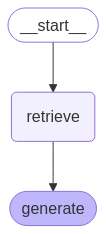

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

# for step in graph.stream(
#     {"question": "What is Task Decomposition?"}, stream_mode="updates"
# ):
#     print(f"{step}\n\n----------------\n")

# for message, metadata in graph.stream(
#     {"question": "What is Task Decomposition?"}, stream_mode="messages"
# ):
#     print(message.content, end="|")

Context: [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of f

In [43]:
len(result["context"])
result["context"][0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [44]:
third = len(splits) // 3

for i, document in enumerate(splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [46]:
vector_store = QdrantVectorStore(client, collection_name="langchain-py-rag-pt1-QA", embedding=embeddings)
vector_store.add_documents(splits)

['2cd4329034304dd3b96478599dcc643f',
 'a1149c9ec21141de80dc31017ae27e25',
 '7b2848b709dc4aadb5d56a7cd409286d',
 '96ba7cdf93ca4bc7a64fc539f5ff4999',
 'aa15b74303fc43539314ef86c616adae',
 'e1f91f33372b49edab7366d7fc801852',
 'c1936d515e2e41b9a3b090548bb6560e',
 '4c25faf63b31486380522e1e414844b5',
 '20116508caef4e47a92c336b7285abad',
 '4826e5d1e458496593be255bbd726d75',
 '1f87afb5316147fd812fb98bca808a26',
 '848efc47e20341b08174bee3b433c771',
 'ea30dfe300734712b0bbd59d75f1e6dd',
 '1df9d72cd1e84a24a93e47b7f654d6fa',
 '71efd9c38ac44202810d34e7fa2bd8ea',
 '3ce20cdb0cea475aa9402bc1b225a958',
 'a2ad35bbc2644150ab3cc2dfdf0d7191',
 '6bad13e8d223455c850e2097376862d1',
 'eba57d282eb84cbcbfde85f9755539c4',
 '27a552bff2bd4e1da6b1d4dfd59745a0',
 'c46bcd29940c46b2a7c80e40f3d1877f',
 '424e126f519b48c9a4c8289f4bc0b6a2',
 'f775fbe1be7e449e899b60dff80ee3f9',
 '58f97bd76a58434ba5a28c587c1504d5',
 'bca6ed258c7341ea8d27f6eb9f46baeb',
 '1a41991429aa4dc2800ab2dbe62024c4',
 'b9ba4ffded414bf085c0ca6c9e4d5889',
 

In [51]:
from typing import Annotated, Literal

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query."
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]

    qa_filter = {
        "must": [
            {
                "key": "metadata.section",
                "match": {
                    "value": query["section"],
                },
            },
        ],
    }

    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=qa_filter,
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

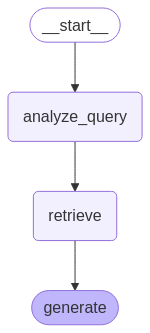

In [48]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'end of the post about Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-